In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score, recall_score,roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import os


In [2]:
df = pd.read_csv('/kaggle/input/cricket-dataset/cricket_dataset.csv')


In [3]:
# EDA
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())
print("\nCorrelation matrix:")
print(df.corr())

Dataset shape: (15691, 5)

First few rows:
   total_runs  wickets  target  balls_left  won
0         0.0      0.0     125       119.0    1
1         0.0      0.0     125       118.0    1
2         1.0      0.0     125       117.0    1
3         1.0      1.0     125       116.0    1
4         1.0      1.0     125       115.0    1

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15691 entries, 0 to 15690
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_runs  15689 non-null  float64
 1   wickets     15689 non-null  float64
 2   target      15691 non-null  int64  
 3   balls_left  15689 non-null  float64
 4   won         15691 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 613.1 KB
None

Descriptive statistics:
         total_runs       wickets        target    balls_left           won
count  15689.000000  15689.000000  15691.000000  15689.000000  15691.000000
mean      71.395691      

In [8]:
# Drop missing values
print("\nDropping missing values...")
initial_shape = df.shape
df = df.dropna()
print(f"Dropped {initial_shape[0] - df.shape[0]} rows with missing values")
print(f"New dataset shape: {df.shape}")

# removing negative balls_left 
print("\nChecking for negative balls_left values...")
negative_balls = df[df['balls_left'] < 0]
if len(negative_balls) > 0:
    print(f"Found {len(negative_balls)} rows with negative balls_left values")
    df = df[df['balls_left'] >= 0]
    print(f"Removed negative balls_left values. New shape: {df.shape}")
else:
    print("No negative balls_left values found")


Dropping missing values...
Dropped 2 rows with missing values
New dataset shape: (15689, 7)

Checking for negative balls_left values...
Found 9 rows with negative balls_left values
Removed negative balls_left values. New shape: (15680, 7)



Class distribution (won):
won
1    9747
0    5933
Name: count, dtype: int64
Percentage of wins: 62.16198979591837


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


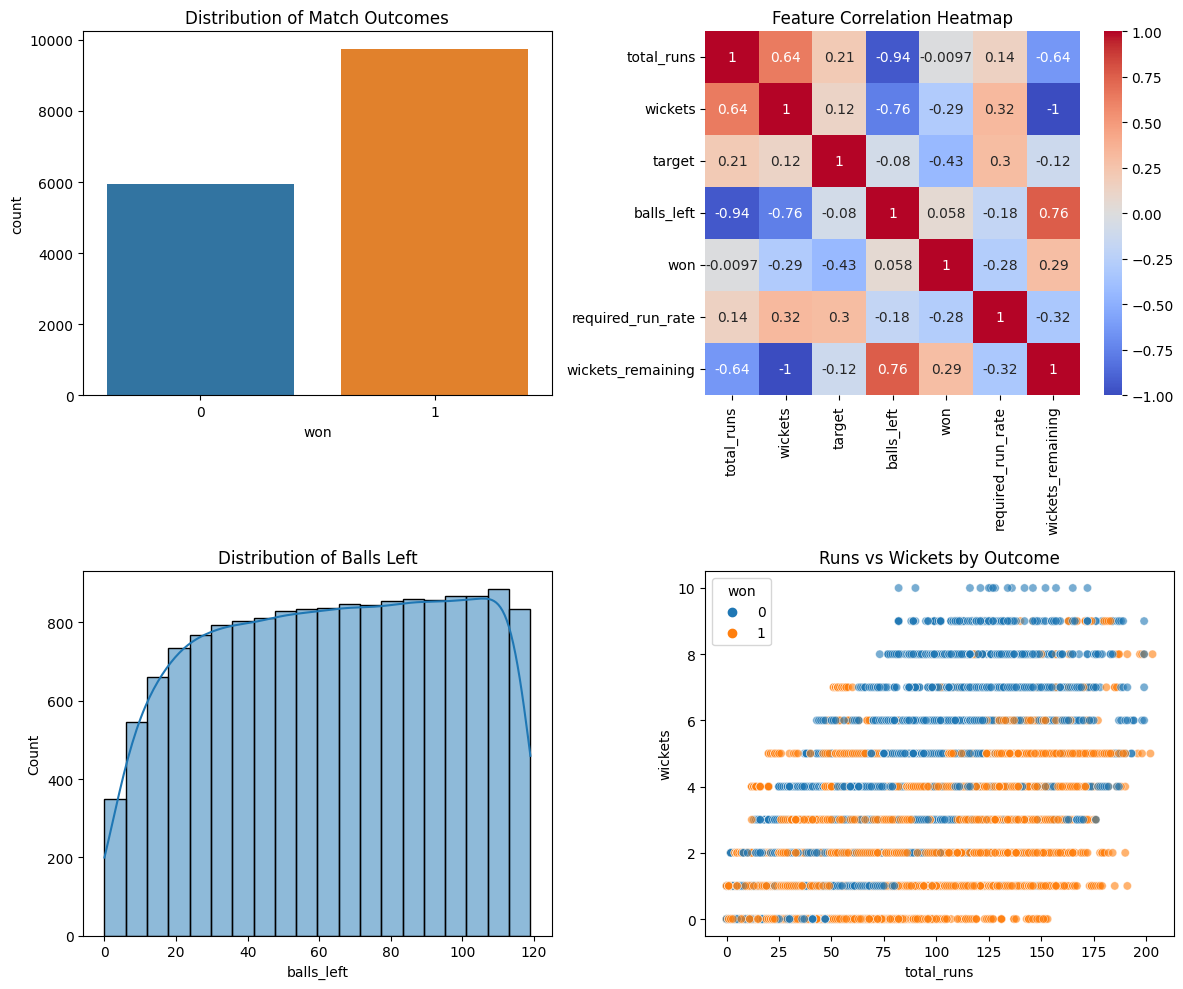

In [9]:
#  class balance
print("\nClass distribution (won):")
print(df['won'].value_counts())
print("Percentage of wins:", df['won'].mean() * 100)

# Visualizations
plt.figure(figsize=(12, 10))

# Distribution of target variable
plt.subplot(2, 2, 1)
sns.countplot(x='won', data=df)
plt.title('Distribution of Match Outcomes')

# Correlation heatmap
plt.subplot(2, 2, 2)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

# Distribution of balls left
plt.subplot(2, 2, 3)
sns.histplot(df['balls_left'], bins=20, kde=True)
plt.title('Distribution of Balls Left')

# Wickets vs runs scatter colored by outcome
plt.subplot(2, 2, 4)
sns.scatterplot(x='total_runs', y='wickets', hue='won', data=df, alpha=0.6)
plt.title('Runs vs Wickets by Outcome')

plt.tight_layout()
plt.savefig('/kaggle/working/eda_visualizations.png')
plt.show()




Correlation matrix after feature engineering:
                   total_runs   wickets    target  balls_left       won  \
total_runs           1.000000  0.638178  0.210742   -0.938791 -0.009684   
wickets              0.638178  1.000000  0.121512   -0.760867 -0.290747   
target               0.210742  0.121512  1.000000   -0.079582 -0.433032   
balls_left          -0.938791 -0.760867 -0.079582    1.000000  0.057599   
won                 -0.009684 -0.290747 -0.433032    0.057599  1.000000   
required_run_rate    0.141763  0.322025  0.303774   -0.183767 -0.275944   
wickets_remaining   -0.638178 -1.000000 -0.121512    0.760867  0.290747   

                   required_run_rate  wickets_remaining  
total_runs                  0.141763          -0.638178  
wickets                     0.322025          -1.000000  
target                      0.303774          -0.121512  
balls_left                 -0.183767           0.760867  
won                        -0.275944           0.290747  
requ

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


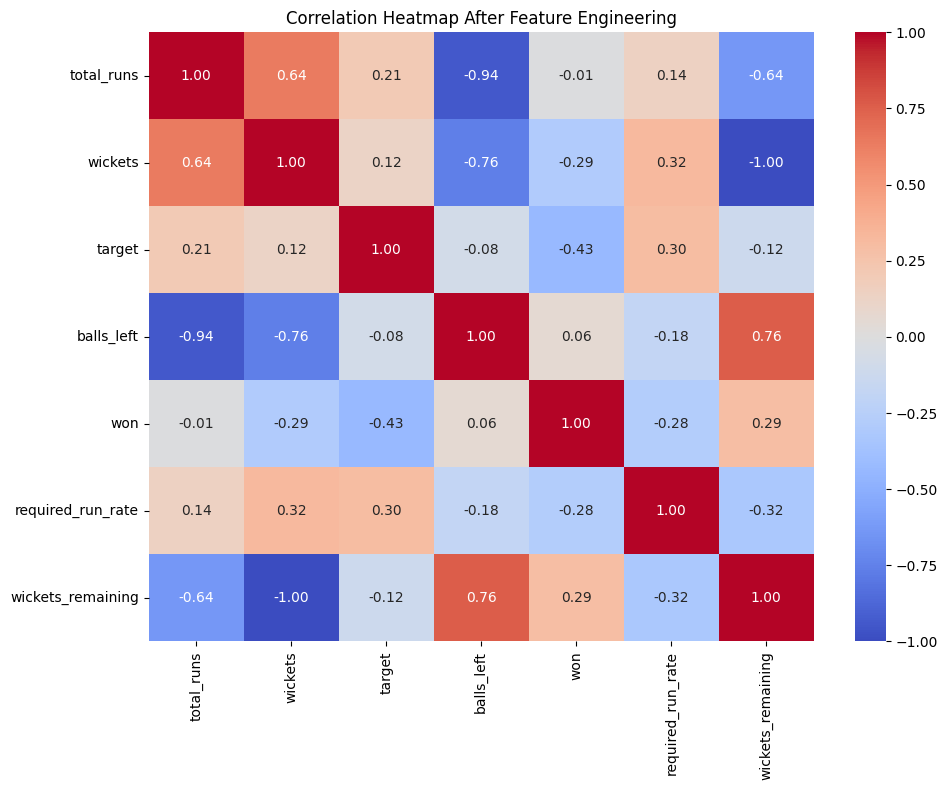


Correlation of new features with target (won):
required_run_rate   -0.275944
wickets_remaining    0.290747
won                  1.000000
Name: won, dtype: float64


In [10]:
# Feature engineering
# required run rate feature
df['required_run_rate'] = (df['target'] - df['total_runs']) / (df['balls_left'] / 6)
df['required_run_rate'] = df['required_run_rate'].replace([np.inf, -np.inf], 0)
df['required_run_rate'] = df['required_run_rate'].fillna(0)

# wickets remaining 
df['wickets_remaining'] = 10 - df['wickets']

# Prepare features and target
X = df[['total_runs', 'wickets', 'target', 'balls_left', 'required_run_rate', 'wickets_remaining']]
y = df['won']

# Check correlation matrix again after feature engineering
print("\nCorrelation matrix after feature engineering:")
print(df.corr())

# correlations with new features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap After Feature Engineering')
plt.tight_layout()
plt.savefig('/kaggle/working/correlation_after_feature_engineering.png')
plt.show()

# Check correlation of new features with target variable
print("\nCorrelation of new features with target (won):")
print(df[['required_run_rate', 'wickets_remaining', 'won']].corr()['won'])


In [11]:
print(df.shape)

(15680, 7)


In [22]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    
    # croass validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"CV F1 Score: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    
    # Training
    model.fit(X_train, y_train)
    
    # testing
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate test metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model,
        'cv_f1': cv_scores.mean(),
        'test_accuracy': accuracy,
        'test_roc_auc': roc_auc,
        'test_f1': f1,
        'test_precision': precision,
        'test_recall': recall
    }

# all models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test, name)

# comapring results
print("\n=== Model Comparison ===")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  CV F1: {metrics['cv_f1']:.4f}")
    print(f"  Test F1: {metrics['test_f1']:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Test ROC AUC: {metrics['test_roc_auc']:.4f}")
    print()

#  best model based on f1 score
best_model_name = max(results, key=lambda x: results[x]['test_f1'])
best_model = results[best_model_name]['model']

print(f"\nBest model based on Test F1 Score: {best_model_name}")

# Save the best model
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open('/kaggle/working/models/trained_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Saved {best_model_name} as trained_model.pkl")


=== Logistic Regression Evaluation ===
CV F1 Score: 0.8313 (±0.0082)
Test Accuracy: 0.7790
Test ROC AUC: 0.8556
Test F1 Score: 0.8275
Test Precision: 0.8037
Test Recall: 0.8527

Confusion Matrix:
[[ 781  406]
 [ 287 1662]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      1187
           1       0.80      0.85      0.83      1949

    accuracy                           0.78      3136
   macro avg       0.77      0.76      0.76      3136
weighted avg       0.78      0.78      0.78      3136


=== Random Forest Evaluation ===
CV F1 Score: 0.9717 (±0.0035)
Test Accuracy: 0.9723
Test ROC AUC: 0.9957
Test F1 Score: 0.9778
Test Precision: 0.9736
Test Recall: 0.9820

Confusion Matrix:
[[1135   52]
 [  35 1914]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1187
           1       0.97      0.98      0.98      1949

    accuracy       